In [6]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
import numpy as np
import networkx as nx

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import MessagePassing

In [20]:
from envs.GraphEnv.impnode import ImpnodeEnv

seed = 5545

In [21]:
env = ImpnodeEnv(anc='nd', ba_nodes=(15, 25), ba_edges = 4,max_removed_nodes = 2, seed=seed, render_option=True, data= False,data_path=False, train_mode=True)

In [22]:
for i in range(1):
    observation , info = env.reset()
    terminated = False
    while terminated is False:
        action = env.action_space.sample(mask=info['node_action_mask'])
        observation, reward, terminated, truncated, info = env.step(action)


Graph is fully disconnected
0.4209517045454545


In [17]:
import torch
import torch.nn as nn

In [141]:
n = 5
p = 3

# Create random tensors
matrix_np_p = torch.rand(n, p)
vector_1_p = torch.rand(1, p)

# Use broadcasting to perform the multiplication
matrix_np_p_p = (matrix_np_p.unsqueeze(2) * vector_1_p.unsqueeze(0).unsqueeze(2)).squeeze(0)
y = nn.Linear(p, 1)(matrix_np_p_p)

# Print the result and its shape
print("matrix_np_p_p shape:", matrix_np_p_p.shape)
print("Result shape:", y.squeeze(2).shape)

matrix_np_p_p shape: torch.Size([5, 3, 3])
Result shape: torch.Size([5, 3])


In [142]:
import torch

# Example tensors
k, n, p = 3, 4, 5
tensor1 = torch.rand(k, n, p)
tensor2 = torch.rand(k, 1, p)

# Broadcasting for element-wise multiplication
result = tensor1 * tensor2.unsqueeze(2)

# Print the shapes
print("Shape of tensor1:", tensor1.shape)
print("Shape of tensor2:", tensor2.shape)
print("Shape of result:", result.shape)


Shape of tensor1: torch.Size([3, 4, 5])
Shape of tensor2: torch.Size([3, 1, 5])
Shape of result: torch.Size([3, 3, 4, 5])


In [143]:
import torch

# Example tensor
tensor = torch.tensor([[1, 2, 3],
                       [4, 5, 6],
                       [7, 8, 9]])




# Concatenate the repeated last row with all rows before it
result = torch.cat((tensor[:-1],tensor[-1].repeat(len(tensor) - 1, 1)), dim=1)


print("\nResult after concatenation:")
print(result)



Result after concatenation:
tensor([[1, 2, 3, 7, 8, 9],
        [4, 5, 6, 7, 8, 9]])


In [144]:
import torch

# Example row matrix
row_matrix = torch.tensor([[1.0, 2.0, 3.0],
                          [4.0, 5.0, 6.0],
                          [7.0, 8.0, 9.0]])

# Compute pairwise Euclidean distances
pairwise_distances = torch.cdist(row_matrix, row_matrix)

upper_triangular = torch.triu(pairwise_distances, diagonal=1)

print("Pairwise Euclidean Distances:")
print(pairwise_distances)
print(upper_triangular)

Pairwise Euclidean Distances:
tensor([[ 0.0000,  5.1962, 10.3923],
        [ 5.1962,  0.0000,  5.1962],
        [10.3923,  5.1962,  0.0000]])
tensor([[ 0.0000,  5.1962, 10.3923],
        [ 0.0000,  0.0000,  5.1962],
        [ 0.0000,  0.0000,  0.0000]])


In [145]:
import torch
from torch_geometric.utils import to_dense_adj

# Example edge index
edge_index = torch.tensor([[0, 1, 1, 2, 2], [1, 0, 2, 1, 2]], dtype=torch.long)

# Convert edge index to adjacency matrix
adjacency_matrix = to_dense_adj(edge_index).squeeze(0)

print("Adjacency Matrix:")
print(adjacency_matrix)

Adjacency Matrix:
tensor([[0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 1.]])


In [146]:
result2 = torch.mul(adjacency_matrix, pairwise_distances)
result2

tensor([[0.0000, 5.1962, 0.0000],
        [5.1962, 0.0000, 5.1962],
        [0.0000, 5.1962, 0.0000]])

In [147]:
sum_of_matrix = torch.sum(result2)/2
sum_of_matrix

tensor(10.3923)

In [148]:
epsilon_min = 0.05
epsilon_step =10
epsilon_max = 1
epsilon = 1
epsilons=[]

In [149]:
for i in range(20):
    epsilon -= (epsilon_max - epsilon_min) / epsilon_step
    epsilon = max(epsilon_min, epsilon)
    epsilons.append(epsilon)

<Axes: >

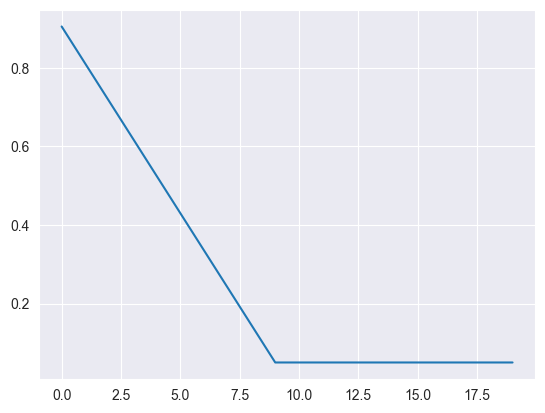

In [150]:
import seaborn as sns
sns.lineplot(epsilons)